## Special Education Practicum.  Interpretation of the polarimetric observations using neural nets.

In this work, the neural network was written from scratch. Below is a step-by-step solution with a description of the actions.

---

**Importing needed libraries and reading the data**

**numpy** - for faster numerical operations  
**pandas** - for reading data  
**matplotlib** - for resulting plots  
**tqdm** - for progress bar while evaluation of neural network  
**warnings** - to depricate warnings, which may occur while calculating exp function with numpy

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import warnings

---

**Reading the data**

In [ ]:
warnings.filterwarnings('ignore')
data = pd.read_table('data.txt', sep='\s+', header=None, names=['m', 'k', 'x', 'theta', 'p_1', 'p_2'])

m = np.asarray(data['m'])
k = np.asarray(data['k'])
x = np.asarray(data['x'])
theta = np.asarray(data['theta'])
p_1 = np.asarray(data['p_1'])
p_2 = np.asarray(data['p_2'])

---

**Checking if the data is OK**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   m       756 non-null    float64
 1   k       756 non-null    float64
 2   x       756 non-null    float64
 3   theta   756 non-null    float64
 4   p_1     756 non-null    float64
 5   p_2     756 non-null    float64
dtypes: float64(6)
memory usage: 35.6 KB


So, it seems all columns were read well, there is no null elements, size and type of all columns are the same.

In [ ]:
data.head(10)

,m,k,x,theta,p_1,p_2
0,1.0,1.5,-0.01,0.0,0.12349,0.12349
1,1.0,1.5,-0.01,30.0,0.11634,0.08993
2,1.0,1.5,-0.01,60.0,0.09855,0.02890
3,1.0,1.5,-0.01,90.0,0.07791,0.00028
4,1.0,1.5,-0.01,120.0,0.06095,0.01244
5,1.0,1.5,-0.01,150.0,0.05055,0.03644
6,1.0,1.5,-0.01,180.0,0.04713,0.04713
7,1.0,1.5,-0.02,0.0,0.12437,0.12437
8,1.0,1.5,-0.02,30.0,0.11720,0.09058
9,1.0,1.5,-0.02,60.0,0.09933,0.02911


_-- Meet! Alice, it's data! Data, it's Alice!_

---

**Defining activation function and its derivative**

I used two activation functions: **Sigmoid** and **ReLU**. They have their advantages and drawbacks (vanishing gradient of Sigmoid or dead ReLU). Let's compare them in the simple case of two-hidden-layers neural network. We may see a little difference in this case, but it is still interesting.

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_diff(z):
    return sigmoid(z)*(1-sigmoid(z))

def relu(x):
    return np.maximum(0, x)

def relu_diff(x):
    return np.where(x > 0, 1, 0)

---

**Defining cost function**

Mean squared error (**MSE**) was chosen, according to homework tutorial we was given.

**y** - actual value  
**a** - predicted value  
**m** - number of training inputs

In [ ]:
def cost(y, a, m):
    return np.sum((y - a)**2)/m

---

**Creating neural network**

It will include two hidden layers, as it was in the example in our tutorial. It's not too simple, but enough to understand the principles of neural networks.
We are solving regression problem, so [I won't use the activation function after the last layer](https://education.yandex.ru/handbook/ml/article/pervoe-znakomstvo-s-polnosvyaznymi-nejrosetyami#mnozhestvennaya-regressiya).

**Forward propagation** function is needed to calculate the results: on training data set, when we just started to teach our model, on testing data - when we are checking how well it works, or on our real data - to solve some problem we wrote this thing for.
**Backward propagation** is needed to evaluate our network. On this step it is learning. **Weights** and **biases** of the linear layers are chosen randomly on the initial and are updating with every epoch, according to the **cost function** derivative.

In [ ]:
class scratch_ANN():
    def __init__(self, f, f_diff, n_in, n_out):
        # Activation function and its derivative
        self.f = f
        self.df = f_diff

        # In and out arrays sizes
        self.n_in = n_in
        self.n_out = n_out

        # Weights and biases. We choose them randomly on the initial.
        self.w_1 = np.random.uniform(size=(n_in, n_in))
        self.w_2 = np.random.uniform(size=(n_in, n_in))
        self.w_3 = np.random.uniform(size=(n_out, n_in))

        self.b_1 = np.random.uniform(size=(n_in))
        self.b_2 = np.random.uniform(size=(n_in))
        self.b_3 = np.random.uniform(size=(n_out))

    def forward_prop(self, x):
        # Input layer
        a_1 = x

        # Hidden layer 1
        z_2 = np.dot(self.w_1, a_1) + self.b_1
        a_2 = self.f(z_2)

        # Hidden layer 2
        z_3 = np.dot(self.w_2, a_2) + self.b_2
        a_3 = self.f(z_3)

        # Output layer
        z_4 = np.dot(self.w_3, a_3) + self.b_3
        o = z_4

        return o, (a_1, a_2, a_3)


    def backward_prop(self, x, y, epochs_num, train_speed, train_amount):
        tsl = int(train_amount * len(x))
        error_values = np.zeros(epochs_num)

        for n in tqdm(range(epochs_num)):

            for x_i, y_i in zip(x[:tsl], y[:tsl]):

                o_i, a_i = self.forward_prop(x_i)
                a_1, a_2, a_3 = a_i

                # Backward propagation
                error_values[n] += cost(y_i, o_i, self.n_out)

                # Output layer
                delta_4 = o_i - y_i
                grad_w_3 = np.outer(delta_4, a_3)
                grad_b_3 = delta_4

                # Hidden layer 2
                delta_3 = self.df(a_3) * np.dot(self.w_3.T, delta_4)
                grad_w_2 = np.outer(delta_3, a_2)
                grad_b_2 = delta_3

                # Hidden layer 1
                delta_2 = self.df(a_2) * np.dot(self.w_2.T, delta_3)
                grad_w_1 = np.outer(delta_2, a_1)
                grad_b_1 = delta_2

                # Update weights and biases
                self.w_3 -= train_speed * grad_w_3
                self.b_3 -= train_speed * grad_b_3

                self.w_2 -= train_speed * grad_w_2
                self.b_2 -= train_speed * grad_b_2

                self.w_1 -= train_speed * grad_w_1
                self.b_1 -= train_speed * grad_b_1

        return error_values

---

**Checking the results**

So, let's see how it works. Initializing nets and packing the data: x (input) consists of 4 parameters an y (outputs) consists of 2.  
We give activation functions, its derivative and number of inputs and outputs for ANNs.

In [ ]:
ann_relu = scratch_ANN(relu, relu_diff, 4, 2)
ann_sigma = scratch_ANN(sigmoid, sigmoid_diff, 4, 2)

x = [[m_i, k_i, x_i, th_i] for m_i, k_i, x_i, th_i in zip(m, k, x, theta)]
y = [[p_1_i, p_2_i] for p_1_i, p_2_i in zip(p_1, p_2)]

Learning our neural network. Let the number of epochs be 100000 and the learning rate 0.0001. The amount of training data = (0.7 * initial data).

In [ ]:
cost_relu = ann_relu.backward_prop(x, y, 100_000, 0.001, 0.7)
cost_sigma = ann_sigma.backward_prop(x, y, 100_000, 0.001, 0.7)

100%|███████████████████████████████████████| 1000/1000 [00:43<00:00, 22.95it/s]


Finally, results plots!

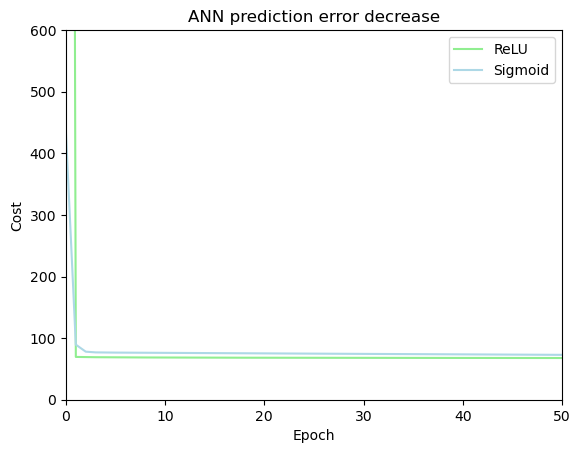

In [ ]:
epochs_grid = np.arange(0, 1000, 1)
plt.plot(epochs_grid, cost_relu, color='lightgreen', ls='-', label='ReLU')
plt.plot(epochs_grid, cost_sigma, color='lightblue', ls='-', label='Sigmoid')
plt.title('ANN prediction error decrease')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.legend()
plt.xlim(0, 50)
plt.ylim(0, 600)
plt.show()